In [1]:
# Librerias utilizadas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import warnings

# Importación de datos

In [2]:
csv_names  = ['df_DHCMA', 'df_CHG', 'df_CHGUADIANA',
            'df_CHS', 'df_DHGB', 'df_DHTOP']
path = '..\\DATA\\'
keys_names = ['Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas', 'Cuenca hidrográfica del Guadalquivir', 'Cuenca hidrográfica del Guadiana',
              'Cuenca hidrográfica del Segura', 'Demarcación Hidrográfica Guadalete-Barbate', 'Demarcación Hidrográfica Tinto, Odiel y Piedras']
df_dict = {key: pd.read_csv(path+value+'.csv', sep=',', encoding='ISO-8859-1')
           for key, value in zip(keys_names, csv_names)}

### Procesado de datos de entrada

In [3]:
# Función de creación de dataset sequencial con arrays de valores input/output
# Este dataset tiene la estructura adecuada para los datos de entrada
# en la red neuronal
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs.iloc[i:(i+seq_size)]
        after_window = obs.iloc[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [4]:
# Creación del dataset de indice SPI_12
spi_12_dict =  {key: value['spi_12']
           for key, value in df_dict.items()}

# Eliminación valores vacios iniciales
for key, df in spi_12_dict.items():           
    spi_12_dict[key] = df.dropna(how='all')       

In [5]:
# Separación en conjunto de entrenamiento y de prueba
# Los datos de prueba empiezan a partir de 2011
spi_12_train_dict, spi_12_test_dict = {}, {}
for key, df in spi_12_dict.items():
    df_train, df_test = train_test_split(df, test_size=0.13, shuffle=False)
    spi_12_train_dict[key] = df_train
    spi_12_test_dict[key] = df_test

In [6]:
# Cálculo de datasets sequenciales
sequence_size = 10
X_train_dict, y_train_dict, X_test_dict,y_test_dict = {}, {}, {}, {}

for key, df in spi_12_train_dict.items():
    X_train,y_train = to_sequences(sequence_size, df)
    X_train_dict[key] = X_train
    y_train_dict[key] = y_train

for key, df in spi_12_test_dict.items():
    X_test,y_test = to_sequences(sequence_size, df)
    X_test_dict[key] = X_test
    y_test_dict[key] = y_test

print("Dimensiones del training set: {}".format(X_train_dict[keys_names[0]].shape))
print("Dimensiones del test set: {}".format(X_test_dict[keys_names[0]].shape))

Dimensiones del training set: (836, 10, 1)
Dimensiones del test set: (117, 10, 1)


# Transformer encoder

In [7]:
# Extraido de https://keras.io/examples/timeseries/timeseries_transformer_classification/
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# Construccion del modelo

In [8]:
# Funcion de construccion del modelo
# Extraida de https://keras.io/examples/timeseries/timeseries_transformer_classification/
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

# Definición del modelo

In [9]:
input_shape = X_train.shape[1:]
def create_model(optimizer='adam'):
    # Arquitectura del modelo
    model = build_model(
        input_shape,
        head_size=256, 
        num_heads=4, # Numero de capas de atencion paralelas
        ff_dim=4, 
        num_transformer_blocks=2, 
        mlp_units=[128], 
        mlp_dropout=0.4,
        dropout=0.25,
    )
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    return model

#  Early stopping para evitar overfitting
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

### Grid search: búsqueda de mejores parámetros

In [10]:
# Transformación del modelo para aplicar grid search
model = KerasRegressor(model=create_model, epochs=100, batch_size=10, verbose=0)

# Parámetros de búsqueda
param_grid = {
    'epochs': [50, 100],
    'batch_size' : [5,10],
    'optimizer' : ['SGD', 'adam']
}


# Se ignoran avisos de ejecución del grid search
warnings.simplefilter("ignore")

# Cálculo de grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=8)
grid_result_dict = {}
for key in spi_12_train_dict.keys():
    grid_result_dict[key] = grid.fit(X_train_dict[key], y_train_dict[key], callbacks=[es], shuffle=False, validation_data=(
        X_test_dict[key], y_test_dict[key]))
    print(key)
    print("Best: %f using %s" % (grid_result_dict[key].best_score_, grid_result_dict[key].best_params_))
    print('')

Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas
Best: 0.851928 using {'batch_size': 5, 'epochs': 50, 'optimizer': 'SGD'}

Cuenca hidrográfica del Guadalquivir
Best: 0.869121 using {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}

Cuenca hidrográfica del Guadiana
Best: 0.865863 using {'batch_size': 10, 'epochs': 50, 'optimizer': 'SGD'}

Cuenca hidrográfica del Segura
Best: 0.876931 using {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}

Demarcación Hidrográfica Guadalete-Barbate
Best: 0.848138 using {'batch_size': 5, 'epochs': 100, 'optimizer': 'SGD'}

Demarcación Hidrográfica Tinto, Odiel y Piedras
Best: 0.864144 using {'batch_size': 5, 'epochs': 50, 'optimizer': 'adam'}



# Entrenamiento del modelo

In [11]:
model_history_dict = {}

for key in spi_12_train_dict.keys():
    model = create_model( grid_result_dict[key].best_params_['optimizer'])

    model_history_dict[key] = model.fit(X_train_dict[key], y_train_dict[key], epochs=grid_result_dict[key].best_params_['epochs'],
        batch_size=grid_result_dict[key].best_params_['batch_size'],
        validation_data=(
        X_test_dict[key], y_test_dict[key]), verbose=2, shuffle=False, callbacks=[es]
        )

Epoch 1/50
168/168 - 3s - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0113 - val_mse: 0.0113 - 3s/epoch - 18ms/step
Epoch 2/50
168/168 - 1s - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0071 - val_mse: 0.0071 - 753ms/epoch - 4ms/step
Epoch 3/50
168/168 - 1s - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0068 - val_mse: 0.0068 - 760ms/epoch - 5ms/step
Epoch 4/50
168/168 - 1s - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0058 - val_mse: 0.0058 - 763ms/epoch - 5ms/step
Epoch 5/50
168/168 - 1s - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0066 - val_mse: 0.0066 - 764ms/epoch - 5ms/step
Epoch 6/50
168/168 - 1s - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0063 - val_mse: 0.0063 - 760ms/epoch - 5ms/step
Epoch 7/50
168/168 - 1s - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0056 - val_mse: 0.0056 - 757ms/epoch - 5ms/step
Epoch 8/50
168/168 - 1s - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0068 - val_mse: 0.0068 - 765ms/epoch - 5ms/step
Epoch 9/50
168/168 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0049 - val_mse:

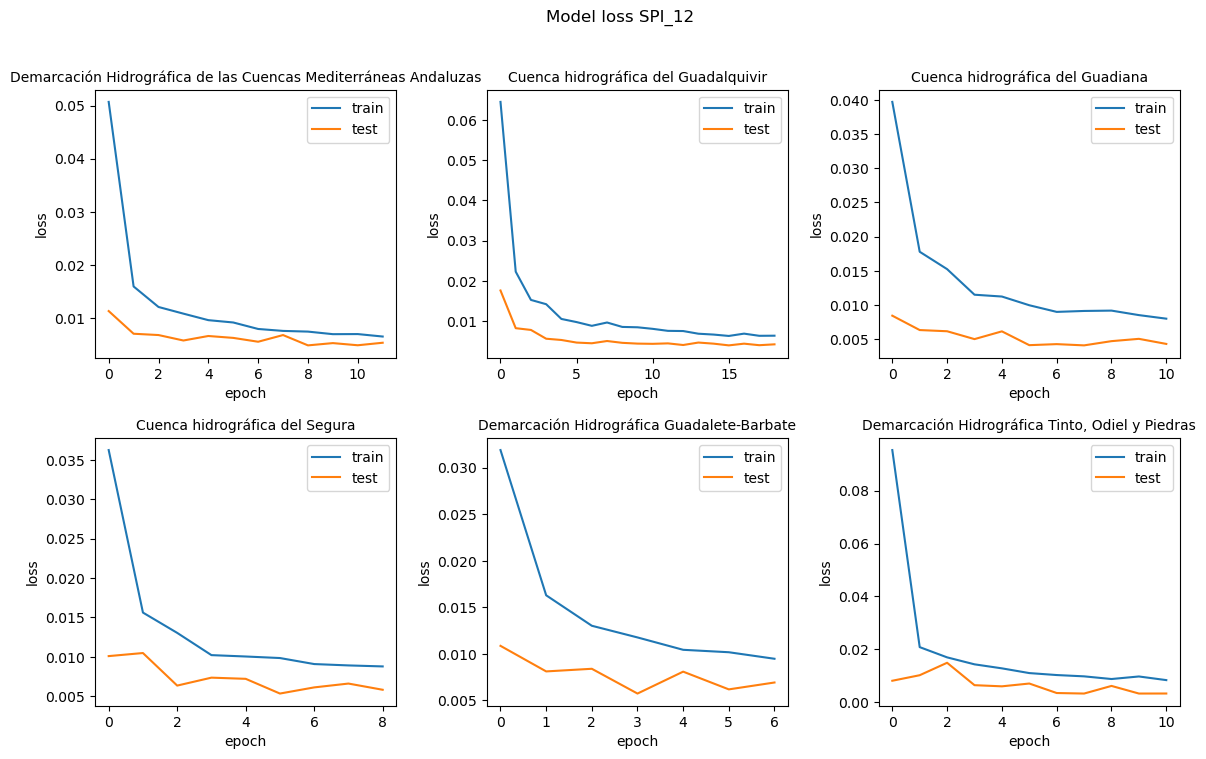

In [12]:
# Resumen del entrenamiento
n_rows = 2
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(14,8))
fig.suptitle('Model loss SPI_12')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, (key, value) in enumerate(model_history_dict.items()):
    if i<n_cols:
        ax[0, i].plot(value.history['loss'])
        ax[0, i].plot(value.history['val_loss'])
        ax[0, i].set_title(key, fontsize=10)
        ax[0, i].set_ylabel('loss')
        ax[0, i].set_xlabel('epoch')
        ax[0, i].legend(['train', 'test'], loc='upper right')
    else:
        ax[1, i-n_cols].plot(value.history['loss'])
        ax[1, i-n_cols].plot(value.history['val_loss'])
        ax[1, i-n_cols].set_title(key, fontsize=10)
        ax[1, i-n_cols].set_ylabel('loss')
        ax[1, i-n_cols].set_xlabel('epoch')
        ax[1, i-n_cols].legend(['train', 'test'], loc='upper right')

# Evaluación del modelo

In [13]:
test_score_values = []
for key in spi_12_dict.keys():
    print('Evaluación '+ key)
    train_prediction = model.predict(X_train_dict[key], verbose=0)
    test_prediction = model.predict(X_test_dict[key], verbose=0)
    train_score = model.evaluate(X_train_dict[key], y_train_dict[key], verbose=0)
    test_score = model.evaluate(X_test_dict[key], y_test_dict[key], verbose=0)
    test_score_values.append(test_score[0])
    print('Train score: {} MSE'.format(train_score[0]))
    print('Test score: {} MSE'.format(test_score[0]))
    print('')

mean_test_score = sum(test_score_values) / len(test_score_values)
print('Mean Test score: {} MSE'.format(mean_test_score))

Evaluación Demarcación Hidrográfica de las Cuencas Mediterráneas Andaluzas
Train score: 0.0051093390211462975 MSE
Test score: 0.005966154858469963 MSE

Evaluación Cuenca hidrográfica del Guadalquivir
Train score: 0.005114030092954636 MSE
Test score: 0.00451473705470562 MSE

Evaluación Cuenca hidrográfica del Guadiana
Train score: 0.005522188264876604 MSE
Test score: 0.004507359117269516 MSE

Evaluación Cuenca hidrográfica del Segura
Train score: 0.004597722552716732 MSE
Test score: 0.004391487687826157 MSE

Evaluación Demarcación Hidrográfica Guadalete-Barbate
Train score: 0.0046253083273768425 MSE
Test score: 0.004392026923596859 MSE

Evaluación Demarcación Hidrográfica Tinto, Odiel y Piedras
Train score: 0.0040464396588504314 MSE
Test score: 0.003308662446215749 MSE

Mean Test score: 0.0045134046813473105 MSE


# Visualización de la predicción

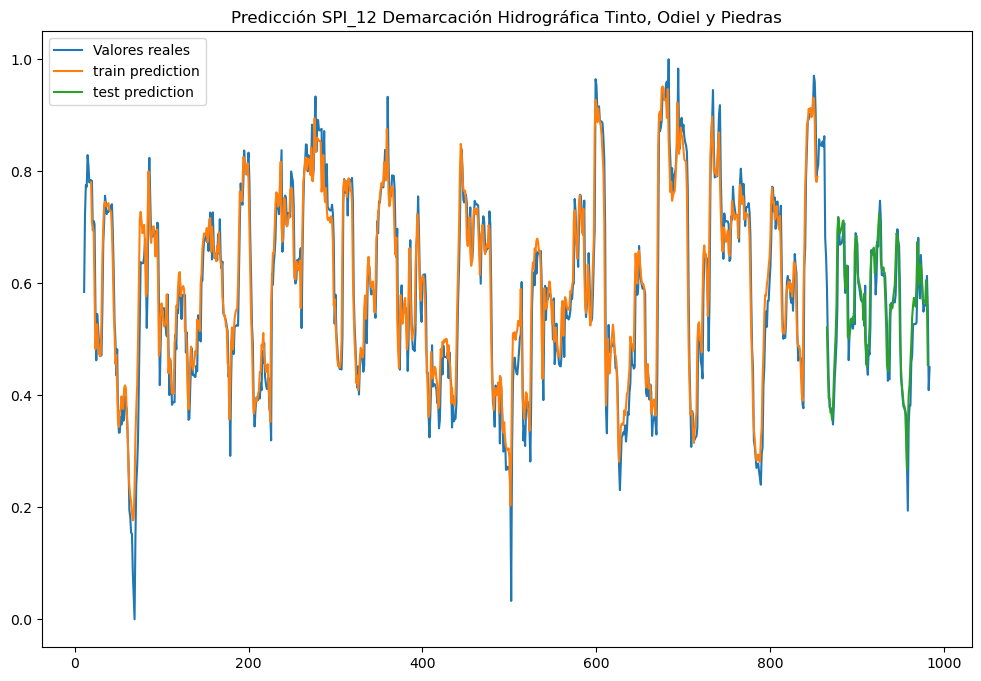

In [14]:
# Gráfica con los valores reales frente a los datos de predicción
# Se usa como ejemplo la predicción de la Demarcación Hidrográfica Tinto, Odiel y Piedras
plt.figure(figsize=(12, 8))
train_stamp = np.arange(9+sequence_size, 9+sequence_size + X_train_dict[keys_names[5]].shape[0])
test_stamp = np.arange(9+2 * sequence_size + X_train_dict[keys_names[5]].shape[0], 9+len(spi_12_dict[keys_names[5]]))
plt.plot(spi_12_dict[keys_names[5]], label='Valores reales')
plt.plot(train_stamp, train_prediction, label='train prediction')
plt.plot(test_stamp, test_prediction, label = 'test prediction')
plt.title('Predicción SPI_12 '+ keys_names[5])
plt.legend()
plt.show()